# Sectiunea 1 - Importarea bibliotecilor și definirea canalelor

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip install wfdb
!pip install mne

import os
import matplotlib.pyplot as plt
#import pyedflib
import wfdb #WFDB (Waveform Database) package
import glob
import random
import gc
import mne
from scipy.signal import find_peaks
import re
import tqdm
import logging

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.7 MB/s eta 0:00:0000:01


Channels of bipolar montage, there are used 18 out of 23:

In [2]:
ch_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3','P3-O1',
           'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
           'FZ-CZ', 'CZ-PZ']

# Secțiunea 2 - Manipularea datelor

I extract the patients IDs

In [3]:
import glob
path = '/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0'

folders = sorted(glob.glob(path+'/*/'))
n_patient = [m[-2:] for m in [l.rsplit('/', 2)[-2] for l in folders]]

print(*n_patient)#the asterix * is for no brackets and commas

01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24


I randomise the patients and select the first 19 for training and last 5 for testing

In [4]:
import random
random.seed(2023)

ratio_train = 0.8
train_patient_str = sorted(random.sample(n_patient, round(ratio_train*len(n_patient))))
test_patient_str = sorted([l for l in n_patient if l not in train_patient_str])
print('Train PT: ', *train_patient_str)
print('Test PT: ', *test_patient_str)

Train PT:  02 03 04 05 06 09 11 12 13 14 15 16 17 18 19 20 21 23 24
Test PT:  01 07 08 10 22


Shows how many files are in total. (train, test)

In [5]:
files_train = []
for l in train_patient_str:
    files_train = files_train + glob.glob(path+'/chb{}/*.edf'.format(l))

files_test = []
for l in test_patient_str:
    files_test = files_test + glob.glob(path+'/chb{}/*.edf'.format(l))
    
len(files_train), len(files_test)

(549, 137)

# Secțiunea 3 - Preprocesarea

In [ ]:
mne.set_log_level(verbose='ERROR') #show only error messages

## Secțiunea 3.1 - Extragerea semnalelor și atribuirea etichetelor 

### Secțiunea 3.1.1. - Secunda 0:

In [ ]:
#creates a logging system information about processed files into a file called 'read_files.log'
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files.log')
logger.addHandler(fh)

#windows overlap 50%
time_window = 8 # 8-second time window
time_step = 4 # slides forward by 4 seconds

p = 0.01  
counter = 0 #how many eeg segments we have in total
#incarcam 
for temp_f in files_train: #temp_f = fisier .edf individual
    temp_edf =  mne.io.read_raw_edf(temp_f) #citeste fiserul edf si creeaza un obiect de tip raw
    temp_labels = temp_edf.ch_names # lista canalelor EEG
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels): #verifies if all channels exist
        time_window = 8
        time_step = 4
        fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
        step_window = time_window*fs #step-window cati pasi sunt intr-o fereastra de 8 secunde
        step = time_step*fs #cât "alunecă" fereastra (4 sec * 256 Hz = 1024 eșantioane)
        #temp_is_sz este un array de 0 și 1 care indică pentru fiecare eșantion dacă se află sau nu se află într-o criză. 
        temp_is_sz = np.zeros((temp_edf.n_times,)) #array cu val 0 pt tot semnalul
        
        #Marcheză porțiunile de semnal în care apar crizele, setând 1 în array-ul temp_is_sz, adica fisierele .edf.seizures
        if os.path.exists(temp_f+'.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size/2)):
                temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1#Marchează cu 1 toate eșantioanele dintre început și sfârșit ca fiind în criză.
                
        #vector cu proportia de criza
        temp_len = temp_edf.n_times
        temp_is_sz_ind = np.array( #temp_is_sz_ind va avea valori între 0 și 1 (0 înseamnă nicio criză, 1 înseamnă criză 100% pe toată fereastra)
            [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]#cat intre 0 si 1 fereastra e in criza
        )

        #calculează câte segmente cu/și fără crize vor fi extrase
        temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size
        counter = counter + temp_0_sample_size + temp_1_sample_size
    temp_edf.close()
    
#creez arrays dupa ce am calculat dimensiunile totale
array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
array_is_sz = np.zeros(counter, dtype=bool)
source_files = []

# citește din nou fișierele și extrage efectiv semnalele
counter = 0
for n, temp_f in enumerate(tqdm.tqdm(files_train)):
    to_log = 'No. {}: Reading. '.format(n)
    temp_edf =  mne.io.read_raw_edf(temp_f)
    temp_labels = temp_edf.ch_names
    n_label_match = sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])
    if n_label_match==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6
        #marcheaza din nou crizele
        if os.path.exists(temp_f+'.seizures'):
            to_log = to_log+'sz exists.'
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size/2)):
                temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
        else:
            to_log = to_log+'No sz.'

        temp_len = temp_edf.n_times

        time_window = 8
        time_step = 4
        fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))#T=intervalul de timp dintre 2 esantioane, apoi frecventa f=1/T de esantionare
        step_window = time_window*fs
        step = time_step*fs

        temp_is_sz_ind = np.array(
            [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
        )
        del temp_is_sz

        temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

        # sz data
        temp_ind = list(np.where(temp_is_sz_ind>0)[0])
        for i in temp_ind:
            array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
            array_is_sz[counter] = True
            source_files.append(temp_f)
            counter = counter+1

        # no sz data
        temp_ind = random.sample(list(np.where(temp_is_sz_ind==0)[0]), temp_0_sample_size)
        for i in temp_ind:
            array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
            array_is_sz[counter] = False
            source_files.append(temp_f)
            counter = counter+1

        to_log += '{} signals added: {} w/o sz, {} w/ sz.'.format(
            temp_0_sample_size+temp_1_sample_size, temp_0_sample_size, temp_1_sample_size
        )

    else:
        to_log += 'Not appropriate channel labels. Reading skipped.'.format(n)
    
    logger.info(to_log)
    temp_edf.close()
#Curăță memoria RAM
    if n%10==0:
        gc.collect()
gc.collect()
# Salvează array-urile rezultate
np.save('/kaggle/working/signal_samples.npy', array_signals)
np.save('/kaggle/working/is_sz.npy', array_is_sz)
np.save('/kaggle/working/source_files.npy', np.array(source_files))

array_signals.shape #(num_windows, num_channels, window_length_samples)

In [ ]:
import numpy as np

# Încărcarea fișierelor din dataset-ul de pe Kaggle
array_signals = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/signal_samples.npy')
array_is_sz = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/is_sz.npy')
source_files = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/source_files.npy', allow_pickle=True)

# Verifică dimensiunea pentru a te asigura că sunt încărcate corect
print(array_signals.shape)
print(array_is_sz.shape)
#au acelasi nuamr de ferestre deoarece array_is_sz e de tip boolean si apare 0 daca fereastra nu are criza si 1 daca contine
print(source_files[:5])  # primele 5 fișiere pentru a verifica

# Checking how much of signals have seizure inside.

array_n = np.where(array_is_sz>.0)[0]
print('Number of all the extracted signals: {}'.format(array_is_sz.size))
print('Number of signals with seizures: {}'.format(array_n.size))
print('Ratio of signals with seizures: {:.3f}'.format(array_n.size/array_is_sz.size))

### Secțiunea 3.1.2. - Secunda 1:

In [ ]:
import numpy as np
import os
import random
import gc
import tqdm
import logging
import mne
import wfdb
import re

# Creează un sistem de logare pentru monitorizarea fișierelor procesate
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files.log')
logger.addHandler(fh)

# Parametrii pentru segmentare
time_window = 8  # Fereastră de 8 secunde
time_step = 4  # Suprapunere de 50% (alunecare de 4 secunde)
p = 0.01  # Proporția de segmente fără crize extrase
counter = 0  # Contor pentru numărul total de segmente EEG extrase

# Se citește fiecare fișier EEG
for temp_f in files_train:  
    temp_edf = mne.io.read_raw_edf(temp_f)  
    temp_labels = temp_edf.ch_names  

    # Verifică dacă toate canalele necesare sunt prezente
    if sum([any([0 if re.match(c, l) is None else 1 for l in temp_edf.ch_names]) for c in ch_labels]) == len(ch_labels):

        fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))  # Rata de eșantionare
        step_window = time_window * fs  # Dimensiunea fiecărei ferestre (în eșantioane)
        step = time_step * fs  # Alunecare de **4 secunde** pentru suprapunere de 50%

        # Începem segmentarea **de la secunda 1** -> calculăm indexul corespunzător în eșantioane
        start_index = fs  # 1 sec * frecvența de eșantionare

        temp_is_sz = np.zeros((temp_edf.n_times,))  # Inițializare array cu 0 (fără criză)

        # Verifică dacă fișierul .seizures există și marchează crizele
        if os.path.exists(temp_f + '.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size / 2)):
                temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1  # Marcare crize

        temp_len = temp_edf.n_times

        # Crearea vectorului de proporție a crizelor **pornind de la secunda 1**
        temp_is_sz_ind = np.array([
            temp_is_sz[start_index + i * step:start_index + i * step + step_window].sum() / step_window
            for i in range((temp_len - start_index - step_window) // step)
        ])

        # Se calculează câte segmente cu și fără crize vor fi extrase
        temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind > 0)[0].size

        counter += temp_0_sample_size + temp_1_sample_size

    temp_edf.close()

# Crearea array-urilor după ce s-au calculat dimensiunile totale
array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
array_is_sz = np.zeros(counter, dtype=bool)
source_files = []

# Citește din nou fișierele și extrage efectiv semnalele
counter = 0
for n, temp_f in enumerate(tqdm.tqdm(files_train)):
    to_log = 'No. {}: Reading. '.format(n)
    temp_edf = mne.io.read_raw_edf(temp_f)

    temp_labels = temp_edf.ch_names
    n_label_match = sum([any([0 if re.match(c, l) is None else 1 for l in temp_edf.ch_names]) for c in ch_labels])

    if n_label_match == len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l) is not None])[0]: c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels) * 1e6

        if os.path.exists(temp_f + '.seizures'):
            to_log += 'sz exists.'
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size / 2)):
                temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1

        temp_len = temp_edf.n_times

        fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))  # Frecvența de eșantionare
        step_window = time_window * fs
        step = time_step * fs  # Acum alunecă 4 secunde pentru suprapunere de 50%

        # **Pornim de la secunda 1**
        start_index = fs  

        temp_is_sz_ind = np.array([
            temp_is_sz[start_index + i * step:start_index + i * step + step_window].sum() / step_window
            for i in range((temp_len - start_index - step_window) // step)
        ])
        del temp_is_sz

        temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind > 0)[0].size

        # Adăugarea semnalelor cu crize
        temp_ind = list(np.where(temp_is_sz_ind > 0)[0])
        for i in temp_ind:
            array_signals[counter, :, :] = temp_signals[:, start_index + i * step:start_index + i * step + step_window]
            array_is_sz[counter] = True
            source_files.append(temp_f)
            counter += 1

        # Adăugarea semnalelor fără crize
        temp_ind = random.sample(list(np.where(temp_is_sz_ind == 0)[0]), temp_0_sample_size)
        for i in temp_ind:
            array_signals[counter, :, :] = temp_signals[:, start_index + i * step:start_index + i * step + step_window]
            array_is_sz[counter] = False
            source_files.append(temp_f)
            counter += 1

        to_log += '{} signals added: {} w/o sz, {} w/ sz.'.format(temp_0_sample_size + temp_1_sample_size, temp_0_sample_size, temp_1_sample_size)

    else:
        to_log += 'Not appropriate channel labels. Reading skipped.'.format(n)

    logger.info(to_log)
    temp_edf.close()

    if n % 10 == 0:
        gc.collect()
gc.collect()

# Salvarea array-urilor rezultate
np.save('/kaggle/working/signal_samples_sec1.npy', array_signals)
np.save('/kaggle/working/is_sz_sec1.npy', array_is_sz)
np.save('/kaggle/working/source_files_sec1.npy', np.array(source_files))

array_signals.shape  # (num_windows, num_channels, window_length_samples)


### Secțiunea 3.1.3. - Secunda 2:

In [ ]:
import numpy as np
import os
import random
import gc
import tqdm
import logging
import mne
import wfdb
import re

# Creează un sistem de logare pentru monitorizarea fișierelor procesate
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files_sec2.log')
logger.addHandler(fh)

# Parametrii pentru segmentare
time_window = 8  # Fereastră de 8 secunde
time_step = 4  # Suprapunere de 50% (alunecare de 4 secunde)
p = 0.01  # Proporția de segmente fără crize extrase
counter = 0  # Contor pentru numărul total de segmente EEG extrase

# Se citește fiecare fișier EEG
for temp_f in files_train:  
    temp_edf = mne.io.read_raw_edf(temp_f, preload=True)  # Optimizare citire
    temp_labels = temp_edf.ch_names  

    # Verifică dacă toate canalele necesare sunt prezente
    if sum([any([0 if re.match(c, l) is None else 1 for l in temp_edf.ch_names]) for c in ch_labels]) == len(ch_labels):

        fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))  # Rata de eșantionare
        step_window = time_window * fs  # Dimensiunea fiecărei ferestre (în eșantioane)
        step = time_step * fs  # Alunecare de **4 secunde** pentru suprapunere de 50%

        # Începem segmentarea **de la secunda 2**
        start_index = 2 * fs  

        temp_is_sz = np.zeros((temp_edf.n_times,))  # Inițializare array cu 0 (fără criză)

        # Verifică dacă fișierul .seizures există și marchează crizele
        if os.path.exists(temp_f + '.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size / 2)):
                temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1  # Marcare crize

        temp_len = temp_edf.n_times

        # Crearea vectorului de proporție a crizelor **pornind de la secunda 2**
        temp_is_sz_ind = np.array([
            temp_is_sz[start_index + i * step:start_index + i * step + step_window].sum() / step_window
            for i in range((temp_len - start_index - step_window) // step)
        ])

        # Se calculează câte segmente cu și fără crize vor fi extrase
        temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind > 0)[0].size

        counter += temp_0_sample_size + temp_1_sample_size

    temp_edf.close()

# Crearea array-urilor după ce s-au calculat dimensiunile totale
array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
array_is_sz = np.zeros(counter, dtype=bool)
source_files = []

# Citește din nou fișierele și extrage efectiv semnalele
counter = 0
for n, temp_f in enumerate(tqdm.tqdm(files_train)):
    to_log = f"No. {n}: Reading {temp_f}."
    temp_edf = mne.io.read_raw_edf(temp_f, preload=True)

    temp_labels = temp_edf.ch_names
    n_label_match = sum([any([0 if re.match(c, l) is None else 1 for l in temp_edf.ch_names]) for c in ch_labels])

    if n_label_match == len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l) is not None])[0]: c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels) * 1e6

        if os.path.exists(temp_f + '.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size / 2)):
                temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1

        temp_len = temp_edf.n_times

        fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))  # Frecvența de eșantionare
        step_window = time_window * fs
        step = time_step * fs  # Acum alunecă 4 secunde pentru suprapunere de 50%

        start_index = 2 * fs  

        temp_is_sz_ind = np.array([
            temp_is_sz[start_index + i * step:start_index + i * step + step_window].sum() / step_window
            for i in range((temp_len - start_index - step_window) // step)
        ])
        del temp_is_sz

        temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind > 0)[0].size

        # Adăugarea semnalelor cu crize
        temp_ind = list(np.where(temp_is_sz_ind > 0)[0])
        for i in temp_ind:
            if start_index + i * step + step_window <= temp_signals.shape[1]:  # Verificare index!
                array_signals[counter, :, :] = temp_signals[:, start_index + i * step:start_index + i * step + step_window]
                array_is_sz[counter] = True
                source_files.append(temp_f)
                counter += 1
            else:
                print(f"Skip segment {counter}: Index out of bounds.")

        # Adăugarea semnalelor fără crize
        temp_ind = random.sample(list(np.where(temp_is_sz_ind == 0)[0]), temp_0_sample_size)
        for i in temp_ind:
            if start_index + i * step + step_window <= temp_signals.shape[1]:  # Verificare index!
                array_signals[counter, :, :] = temp_signals[:, start_index + i * step:start_index + i * step + step_window]
                array_is_sz[counter] = False
                source_files.append(temp_f)
                counter += 1
            else:
                print(f"Skip segment {counter}: Index out of bounds.")

        to_log += f" {temp_0_sample_size + temp_1_sample_size} signals added: {temp_0_sample_size} w/o sz, {temp_1_sample_size} w/ sz."
    else:
        to_log += " Not appropriate channel labels. Skipped."

    logger.info(to_log)
    temp_edf.close()

    if n % 10 == 0:
        gc.collect()
gc.collect()

# **Salvarea fișierelor**
np.save('/kaggle/working/signal_samples_sec2.npy', array_signals)
np.save('/kaggle/working/is_sz_sec2.npy', array_is_sz)
np.save('/kaggle/working/source_files_sec2.npy', np.array(source_files))

array_signals.shape  # (num_windows, num_channels, window_length_samples)

### Secțiunea 3.1.3. - Secunda 3:

In [ ]:
import numpy as np
import os
import random
import gc
import tqdm
import logging
import mne
import wfdb
import re

# Setare sistem de logare
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files_sec3.log')
logger.addHandler(fh)

# Parametrii pentru segmentare
time_window = 8  
time_step = 4  
p = 0.01  
counter = 0  

# Citirea fișierelor EEG
for temp_f in files_train:  
    temp_edf = mne.io.read_raw_edf(temp_f, preload=True)  
    temp_labels = temp_edf.ch_names  

    if sum([any([0 if re.match(c, l) is None else 1 for l in temp_edf.ch_names]) for c in ch_labels]) == len(ch_labels):

        fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))  
        step_window = time_window * fs  
        step = time_step * fs  

        start_index = 3 * fs  

        temp_is_sz = np.zeros((temp_edf.n_times,))  

        if os.path.exists(temp_f + '.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size / 2)):
                temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1  

        temp_len = temp_edf.n_times

        temp_is_sz_ind = np.array([
            temp_is_sz[start_index + i * step:start_index + i * step + step_window].sum() / step_window
            for i in range((temp_len - start_index - step_window) // step)
        ])

        temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind > 0)[0].size

        counter += temp_0_sample_size + temp_1_sample_size

    temp_edf.close()

# Crearea array-urilor după calcul
array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
array_is_sz = np.zeros(counter, dtype=bool)
source_files = []

# Citirea fișierelor și extragerea semnalelor
counter = 0
for n, temp_f in enumerate(tqdm.tqdm(files_train)):
    to_log = f"No. {n}: Reading {temp_f}."
    temp_edf = mne.io.read_raw_edf(temp_f, preload=True)

    temp_labels = temp_edf.ch_names
    n_label_match = sum([any([0 if re.match(c, l) is None else 1 for l in temp_edf.ch_names]) for c in ch_labels])

    if n_label_match == len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l) is not None])[0]: c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels) * 1e6

        if os.path.exists(temp_f + '.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size / 2)):
                temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1

        temp_len = temp_edf.n_times

        fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))  
        step_window = time_window * fs
        step = time_step * fs  

        start_index = 3 * fs  

        temp_is_sz_ind = np.array([
            temp_is_sz[start_index + i * step:start_index + i * step + step_window].sum() / step_window
            for i in range((temp_len - start_index - step_window) // step)
        ])
        del temp_is_sz

        temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
        temp_1_sample_size = np.where(temp_is_sz_ind > 0)[0].size

        temp_ind = list(np.where(temp_is_sz_ind > 0)[0])
        for i in temp_ind:
            if start_index + i * step + step_window <= temp_signals.shape[1]:  
                array_signals[counter, :, :] = temp_signals[:, start_index + i * step:start_index + i * step + step_window]
                array_is_sz[counter] = True
                source_files.append(temp_f)
                counter += 1

        temp_ind = random.sample(list(np.where(temp_is_sz_ind == 0)[0]), temp_0_sample_size)
        for i in temp_ind:
            if start_index + i * step + step_window <= temp_signals.shape[1]:  
                array_signals[counter, :, :] = temp_signals[:, start_index + i * step:start_index + i * step + step_window]
                array_is_sz[counter] = False
                source_files.append(temp_f)
                counter += 1

        to_log += f" {temp_0_sample_size + temp_1_sample_size} signals added: {temp_0_sample_size} w/o sz, {temp_1_sample_size} w/ sz."
    else:
        to_log += " Not appropriate channel labels. Skipped."

    logger.info(to_log)
    temp_edf.close()

    if n % 10 == 0:
        gc.collect()
gc.collect()

# Salvarea fișierelor
np.save('/kaggle/working/signal_samples_sec3.npy', array_signals)
np.save('/kaggle/working/is_sz_sec3.npy', array_is_sz)
np.save('/kaggle/working/source_files_sec3.npy', np.array(source_files))

array_signals.shape  

### Secțiunea 3.1.4. - Setul de test

In [ ]:
import numpy as np
import mne
import os
import wfdb
import tqdm
import gc
import random
import logging

# Setăm logger pentru a salva informațiile despre fișierele procesate
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files.log')
logger.addHandler(fh)

# Parametri
time_window = 8  # Fereastră de 8 secunde
time_step = 4  # Overlap 50%
p = 0.01  # Proporție eșantioane fără crize
counter = 0  # Contor pentru numărul total de ferestre

print("Calcul dimensiuni totale...")
for temp_f in tqdm.tqdm(files_train, desc="Estimare dimensiune dataset"):
    temp_edf = mne.io.read_raw_edf(temp_f, preload=True) 
    fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))  
    step_window = time_window * fs  
    step = time_step * fs  

    temp_is_sz = np.zeros((temp_edf.n_times,))  
    if os.path.exists(temp_f + '.seizures'):
        temp_annotation = wfdb.rdann(temp_f, 'seizures')
        for i in range(int(temp_annotation.sample.size / 2)):
            temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1  

    temp_len = temp_edf.n_times
    temp_is_sz_ind = np.array([temp_is_sz[i * step:i * step + step_window].sum() / step_window for i in range((temp_len - step_window) // step)])

    temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)  
    temp_1_sample_size = np.where(temp_is_sz_ind > 0)[0].size  

    counter += temp_0_sample_size + temp_1_sample_size
    temp_edf.close()

# Inițializează array-urile
X_test = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
y_test = np.zeros(counter, dtype=bool)

# Extrage semnalele și etichetele
counter = 0
print("Procesare fișiere EEG...")
for n, temp_f in tqdm.tqdm(enumerate(files_train), total=len(files_train), desc="Extrage semnale"):
    temp_edf = mne.io.read_raw_edf(temp_f, preload=True)

    # Verifică și selectează doar canalele existente
    available_channels = [ch for ch in ch_labels if ch in temp_edf.ch_names]
    if len(available_channels) == len(ch_labels):  # Verifică dacă toate sunt prezente
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None])[0]: c for c in available_channels}
        temp_edf.rename_channels(ch_mapping)
        temp_edf = temp_edf.pick(available_channels)  # Selectează doar canalele relevante

        temp_signals = temp_edf.get_data(picks=available_channels) * 1e6
        temp_is_sz = np.zeros((temp_edf.n_times,))

        # Marchează crizele
        if os.path.exists(temp_f + '.seizures'):
            temp_annotation = wfdb.rdann(temp_f, 'seizures')
            for i in range(int(temp_annotation.sample.size / 2)):
                temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1

        temp_len = temp_edf.n_times
        temp_is_sz_ind = np.array([temp_is_sz[i * step:i * step + step_window].sum() / step_window for i in range((temp_len - step_window) // step)])

        # Extrage segmente cu crize
        temp_ind = list(np.where(temp_is_sz_ind > 0)[0])
        for i in tqdm.tqdm(temp_ind, desc="Ferestre criză", leave=False):
            if counter < X_test.shape[0]:  
                X_test[counter, :, :] = temp_signals[:, i * step:i * step + step_window]
                y_test[counter] = 1
                counter += 1

        # Extrage segmente fără crize
        temp_ind = random.sample(list(np.where(temp_is_sz_ind == 0)[0]), temp_0_sample_size)
        for i in tqdm.tqdm(temp_ind, desc="Ferestre fără criză", leave=False):
            if counter < X_test.shape[0]:  
                X_test[counter, :, :] = temp_signals[:, i * step:i * step + step_window]
                y_test[counter] = 0
                counter += 1

    else:
        print(f"Fișier {temp_f} ignorat - canale lipsă: {[ch for ch in ch_labels if ch not in temp_edf.ch_names]}")

    temp_edf.close()
    if n % 10 == 0:
        gc.collect()

gc.collect()

# Salvează array-urile
np.save('/kaggle/working/signal_samples.npy', X_test)
np.save('/kaggle/working/is_sz.npy', y_test)

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


In [6]:
mne.set_log_level(verbose='ERROR') #show only error messages

In [8]:
time_window = 8  # Fereastră de 8 secunde
time_step = 4  # Overlap 50%
p = 0.01  # Proporție eșantioane fără crize
counter = 0  # Contor pentru numărul total de ferestre

secunda = 3
X = []
y = []

for temp_f in tqdm.tqdm(files_train, desc="Secunda 3"):
    temp_edf = mne.io.read_raw_edf(temp_f, preload=True)
    fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))
    step_window = time_window * fs
    step = time_step * fs

    if all(ch in temp_edf.ch_names for ch in ch_labels):
        temp_edf.pick_channels(ch_labels)
        signal = temp_edf.get_data() * 1e6
        is_sz = np.zeros(temp_edf.n_times)

        if os.path.exists(temp_f + '.seizures'):
            ann = wfdb.rdann(temp_f, 'seizures')
            for i in range(len(ann.sample) // 2):
                is_sz[ann.sample[2*i]:ann.sample[2*i+1]] = 1

        start = secunda * fs
        for i in range((len(is_sz) - start - step_window) // step):
            s = start + i * step
            e = s + step_window
            segment = signal[:, s:e]
            label = is_sz[s:e].sum() / step_window
            X.append(segment)
            y.append(int(label > 0))

    temp_edf.close()
    gc.collect()

np.save('/kaggle/working/signal_samples_sec3.npy', np.array(X))
np.save('/kaggle/working/is_sz_sec3.npy', np.array(y))


Secunda 3: 100%|██████████| 549/549 [09:55<00:00,  1.08s/it]


In [ ]:
import numpy as np

# Încarcă array-ul
y_test = np.load('/kaggle/input/testing-dataset/is_sz.npy')

# Convertirea valorilor True/False în 1/0
y_test = y_test.astype(int)

# Salvează modificările
np.save('/kaggle/working/is_sz_numeric.npy', y_test)

print(f"y_test shape: {y_test.shape}")
print(f"Primele valori din y_test: {y_test[:10]}")

In [ ]:
import pandas as pd

# Crează un DataFrame cu y_test
df = pd.DataFrame(y_test, columns=['Seizure'])

# Salvează într-un fișier CSV
df.to_csv('/kaggle/working/y_test.csv', index=False)

print("Fișierul y_test.csv a fost salvat cu succes!")


### Secțiunea 3.1.5. - Concatenarea seturilor de date

In [ ]:
import numpy as np

#original

# Încărcarea fișierelor din dataset-ul de pe Kaggle
array_signals = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/signal_samples.npy')
array_is_sz = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/is_sz.npy')
source_files = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/source_files.npy', allow_pickle=True)

# Verifică dimensiunea pentru a te asigura că sunt încărcate corect
print(array_signals.shape)
print(array_is_sz.shape)
#au acelasi nuamr de ferestre deoarece array_is_sz e de tip boolean si apare 0 daca fereastra nu are criza si 1 daca contine
#print(source_files[:5])  # primele 5 fișiere pentru a verifica

# Checking how much of signals have seizure inside.

array_n = np.where(array_is_sz>.0)[0]
print('Number of all the extracted signals original: {}'.format(array_is_sz.size))
print('Number of signals with seizures original: {}'.format(array_n.size))
print('Ratio of signals with seizures original: {:.3f}'.format(array_n.size/array_is_sz.size))

#----------------------------------------------------------------------------------------------------
#sec1


# Încărcarea fișierelor din dataset-ul de pe Kaggle
array_signals_1 = np.load('/kaggle/input/eeg-processed-samples-sec1/signal_samples_sec1.npy')
array_is_sz_1 = np.load('/kaggle/input/eeg-processed-samples-sec1/is_sz_sec1.npy')
source_files_1 = np.load('/kaggle/input/eeg-processed-samples-sec1/source_files_sec1.npy', allow_pickle=True)

# Verifică dimensiunea pentru a te asigura că sunt încărcate corect
print(array_signals_1.shape)
print(array_is_sz_1.shape)
#au acelasi nuamr de ferestre deoarece array_is_sz e de tip boolean si apare 0 daca fereastra nu are criza si 1 daca contine
#print(source_files_1[:5])  # primele 5 fișiere pentru a verifica

# Checking how much of signals have seizure inside.

array_n_1 = np.where(array_is_sz_1>.0)[0]
print('Number of all the extracted signals sec1: {}'.format(array_is_sz_1.size))
print('Number of signals with seizures sec1: {}'.format(array_n_1.size))
print('Ratio of signals with seizures sec1: {:.3f}'.format(array_n_1.size/array_is_sz_1.size))

#---------------------------------------------------------------------------------------------------
#sec2

# Încărcarea fișierelor din dataset-ul de pe Kaggle
array_signals_2 = np.load('/kaggle/input/eeg-processed-samples-sec2/signal_samples_sec2.npy')
array_is_sz_2 = np.load('/kaggle/input/eeg-processed-samples-sec2/is_sz_sec2.npy')
source_files_2 = np.load('/kaggle/input/eeg-processed-samples-sec2/source_files_sec2.npy', allow_pickle=True)

# Verifică dimensiunea pentru a te asigura că sunt încărcate corect
print(array_signals_2.shape)
print(array_is_sz_2.shape)
#au acelasi nuamr de ferestre deoarece array_is_sz e de tip boolean si apare 0 daca fereastra nu are criza si 1 daca contine
#print(source_files[:5])  # primele 5 fișiere pentru a verifica

# Checking how much of signals have seizure inside.

array_n_2 = np.where(array_is_sz_2>.0)[0]
print('Number of all the extracted signals sec2: {}'.format(array_is_sz_2.size))
print('Number of signals with seizures sec2: {}'.format(array_n_2.size))
print('Ratio of signals with seizures sec2: {:.3f}'.format(array_n_2.size/array_is_sz_2.size))

#---------------------------------------------------------------------------------------
#sec3

# Încărcarea fișierelor din dataset-ul de pe Kaggle
array_signals_3 = np.load('/kaggle/input/eeg-processed-samples-sec3/signal_samples_sec3.npy')
array_is_sz_3 = np.load('/kaggle/input/eeg-processed-samples-sec3/is_sz_sec3.npy')
source_files_3 = np.load('/kaggle/input/eeg-processed-samples-sec3/source_files_sec3.npy', allow_pickle=True)

# Verifică dimensiunea pentru a te asigura că sunt încărcate corect
print(array_signals_3.shape)
print(array_is_sz_3.shape)
#au acelasi nuamr de ferestre deoarece array_is_sz e de tip boolean si apare 0 daca fereastra nu are criza si 1 daca contine
#print(source_files[:5])  # primele 5 fișiere pentru a verifica

# Checking how much of signals have seizure inside.

array_n_3 = np.where(array_is_sz_3>.0)[0]
print('Number of all the extracted signals sec3: {}'.format(array_is_sz_3.size))
print('Number of signals with seizures sec3: {}'.format(array_n_3.size))
print('Ratio of signals with seizures sec3: {:.3f}'.format(array_n_3.size/array_is_sz_3.size))

In [ ]:
import numpy as np

# Încărcarea seturilor de date
array_signals_0 = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/signal_samples.npy')
array_is_sz_0 = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/is_sz.npy')

array_signals_1 = np.load('/kaggle/input/eeg-processed-samples-sec1/signal_samples_sec1.npy')
array_is_sz_1 = np.load('/kaggle/input/eeg-processed-samples-sec1/is_sz_sec1.npy')

array_signals_2 = np.load('/kaggle/input/eeg-processed-samples-sec2/signal_samples_sec2.npy')
array_is_sz_2 = np.load('/kaggle/input/eeg-processed-samples-sec2/is_sz_sec2.npy')

array_signals_3 = np.load('/kaggle/input/eeg-processed-samples-sec3/signal_samples_sec3.npy')
array_is_sz_3 = np.load('/kaggle/input/eeg-processed-samples-sec3/is_sz_sec3.npy')

# Verificarea dimensiunilor pentru compatibilitate
print("Dimensiuni semnale:")
print(array_signals_0.shape, array_signals_1.shape, array_signals_2.shape, array_signals_3.shape)
print("Dimensiuni etichete:")
print(array_is_sz_0.shape, array_is_sz_1.shape, array_is_sz_2.shape, array_is_sz_3.shape)

# Concatenarea semnalelor EEG
array_signals_all = np.concatenate((array_signals_0, array_signals_1, array_signals_2, array_signals_3), axis=0)

# Concatenarea etichetelor de criză
array_is_sz_all = np.concatenate((array_is_sz_0, array_is_sz_1, array_is_sz_2, array_is_sz_3), axis=0)

# Salvarea dataset-ului complet
np.save('/kaggle/working/signal_samples_all.npy', array_signals_all)
np.save('/kaggle/working/is_sz_all.npy', array_is_sz_all)

# Verificare finală
print("Dimensiunea dataset-ului final:")
print(array_signals_all.shape)
print(array_is_sz_all.shape)


In [ ]:
import numpy as np

# Încărcarea seturilor de date
array_signals_0 = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/signal_samples.npy')
array_is_sz_0 = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/is_sz.npy')

array_signals_1 = np.load('/kaggle/input/eeg-processed-samples-sec1/signal_samples_sec1.npy')
array_is_sz_1 = np.load('/kaggle/input/eeg-processed-samples-sec1/is_sz_sec1.npy')

array_signals_2 = np.load('/kaggle/input/eeg-processed-samples-sec2/signal_samples_sec2.npy')
array_is_sz_2 = np.load('/kaggle/input/eeg-processed-samples-sec2/is_sz_sec2.npy')

array_signals_3 = np.load('/kaggle/input/eeg-processed-samples-sec3/signal_samples_sec3.npy')
array_is_sz_3 = np.load('/kaggle/input/eeg-processed-samples-sec3/is_sz_sec3.npy')

# Filtrarea doar a segmentelor cu crize pentru secundele 1, 2 și 3
array_signals_1_filtered = array_signals_1[array_is_sz_1]
array_signals_2_filtered = array_signals_2[array_is_sz_2]
array_signals_3_filtered = array_signals_3[array_is_sz_3]

# Concatenarea datelor: toate ferestrele de la secunda 0 + doar cele cu crize de la secundele 1, 2 și 3
array_signals_more_seizures = np.concatenate((array_signals_0, array_signals_1_filtered, array_signals_2_filtered, array_signals_3_filtered), axis=0)

# Etichetele aferente
array_is_sz_more_seizures = np.concatenate((array_is_sz_0, np.ones(array_signals_1_filtered.shape[0], dtype=bool), np.ones(array_signals_2_filtered.shape[0], dtype=bool), np.ones(array_signals_3_filtered.shape[0], dtype=bool)), axis=0)

# Salvarea dataset-ului rezultat
np.save('/kaggle/working/signal_samples_filtered.npy', array_signals_more_seizures)
np.save('/kaggle/working/is_sz_filtered.npy', array_is_sz_more_seizures)

# Verificare finală
print("Dimensiunea dataset-ului final:")
print(array_signals_more_seizures.shape)
print(array_is_sz_more_seizures.shape)

Total segmente: 9505
Crize: 2581 (27.15%)
Fără crize: 6924 (72.85%)


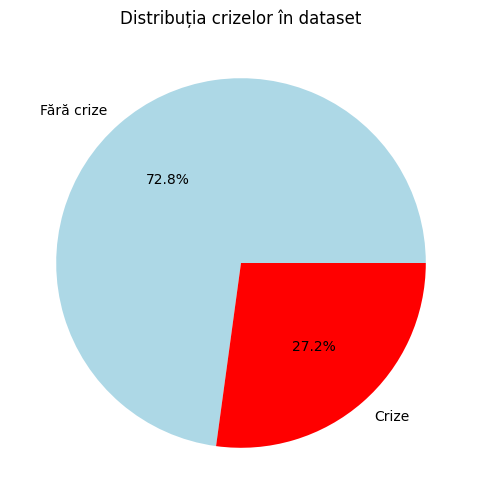

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Încărcarea etichetelor
array_is_sz_all = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/is_sz.npy')

# Calculul proporțiilor
num_sz = np.sum(array_is_sz_all)  # Numărul de segmente cu crize
num_total = array_is_sz_all.shape[0]  # Numărul total de segmente
num_non_sz = num_total - num_sz  # Numărul de segmente fără crize

# Afișarea rezultatelor
print(f"Total segmente: {num_total}")
print(f"Crize: {num_sz} ({num_sz / num_total:.2%})")
print(f"Fără crize: {num_non_sz} ({num_non_sz / num_total:.2%})")

#----------------------------------------------------------------------------------

# Crearea unui grafic de distribuție
labels = ['Fără crize', 'Crize']
sizes = [num_non_sz, num_sz]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['lightblue', 'red'])
plt.title('Distribuția crizelor în dataset')
plt.show()


## Secțiunea 3.2 - Graphics: Samples of extracted signals

In [ ]:
# show a sample of extracted signals, one plot, the first two and the last two

import matplotlib.pyplot as plt
vertical_width = 250
#----------------------------------------------------------
#frecventa 2048
signals = array_signals[1, :, :]
fs = 128 #the frequency was resampled

fig, ax = plt.subplots()
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()
#---------------------------frecventa 1024
signals = array_signals[1, :, ::2]
fs = 128 #the frequency was resampled

fig, ax = plt.subplots()
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()
#-----------------------------primele 3 canale
signals = array_signals[1, :3, ::2]
fs = 128 #the frequency was resampled

fig, ax = plt.subplots()
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()
#-------------------------------------------------------
signals = array_signals[2, :, ::2]
fs = 128 #the frequency was resampled

fig, ax = plt.subplots(figsize=(15, 6))
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()
#-------------------------------------------------------
signals = array_signals[-2, :, ::2]
fs = 128 #the frequency was resampled

fig, ax = plt.subplots(figsize=(10, 8))
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()
#----------------------------------------------------------
signals = array_signals[-1, :, ::2]
fs = 128 #the frequency was resampled

fig, ax = plt.subplots(figsize=(10, 6))
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()

In [ ]:
# Samples with seizures. Two plots, with heatmaps
import random
import os

for n in random.sample(list(array_n), 10):
    temp_signals = array_signals[n, :, :]
    fs = 128
    vertical_width = 300
    file_origin = source_files[n]
    file_short = os.path.basename(file_origin)

    #creeaza grafic cu 2 sub-grafice
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})
    
    # Subgraficul 0 - semnal EEG (multi-canal)
    for i in range(temp_signals.shape[0]):
        ax[0].plot(np.arange(temp_signals.shape[-1]) / fs,
                   temp_signals[i, :] + i * vertical_width,
                   linewidth=0.5, color='tab:blue')
        ax[0].annotate(ch_labels[i], xy=(0, i * vertical_width))
    
    ax[0].invert_yaxis()
    ax[0].set_xlim(0, 8)
    ax[0].set_title(f'Sample no. {n} | Source: {file_short}')

    # Subgraficul 1 - heatmap
    ax[1].pcolormesh(np.arange(temp_signals.shape[-1]) / fs,
                     np.arange(len(ch_labels)),
                     temp_signals[:, :], cmap='gray')
    ax[1].invert_yaxis()

    plt.tight_layout()
    plt.show()

## Secțiunea 3.3 - Încărcare datasets

In [ ]:
#random seed 17
import numpy as np

array_signals = np.load('/kaggle/input/eeg-processed-samples/signal_samples.npy')
array_is_sz = np.load('/kaggle/input/eeg-processed-samples/is_sz.npy')
source_files = np.load('/kaggle/input/eeg-processed-samples/source_files.npy', allow_pickle=True)

In [35]:
#random seed 2023
import numpy as np

array_signals = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/signal_samples.npy')
array_is_sz = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/is_sz.npy')
source_files = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/source_files.npy', allow_pickle=True)

In [ ]:
#random seed 2023 FINAL
import numpy as np

array_signals = np.load('/kaggle/input/eeg-processed-final/signal_samples_all.npy')
array_is_sz = np.load('/kaggle/input/eeg-processed-final/is_sz_all.npy')
#source_files = np.load('/kaggle/input/eeg-seizure-dedtection-rs2023/source_files.npy', allow_pickle=True)

## Secțiunea 3.4.- Channel dimension and data split

In [36]:
array_signals = array_signals[:, :, ::2]
array_signals.shape

(9505, 18, 1024)

In [37]:
# CNN will be used. Channel dimension is added.

array_signals = array_signals[:, :, :, np.newaxis]

array_signals.shape

(9505, 18, 1024, 1)

In [39]:
#Split data
import numpy as np
from sklearn import model_selection
from sklearn.model_selection import train_test_split

# Împărțim datele: 80% pentru antrenare, 20% pentru testare
X_train, X_validation, y_train, y_validation = train_test_split(
    array_signals,        # semnalele EEG
    array_is_sz,          # etichetele (True = criză, False = non-criză)
    test_size=0.15,        # 30% din date merg în setul de test
    random_state=42,      # pentru reproductibilitate
    stratify=array_is_sz  # păstrează proporția dintre clase (criză/non-criză)
)
print("X_train dimension:", X_train.shape)
print("y_train dimension:", y_train.shape)
print("X_validation dimension:", X_validation.shape)
print("y_validation dimension:", y_validation.shape)


# Funcție pentru afișarea distribuției etichetelor
def show_distribution(y, name):
    unique, counts = np.unique(y, return_counts=True)
    total = counts.sum()
    print(f"\nDistribuție {name}:")
    for val, cnt in zip(unique, counts):
        pct = 100 * cnt / total
        label = "seizure" if val == 1 else "non-criză"
        print(f"  {label} ({val}): {cnt} ({pct:.2f}%)")

# Afișarea distribuției
show_distribution(y_train, "y_train")
show_distribution(y_validation, "y_validaion")

from sklearn.utils.class_weight import compute_class_weight


# Calculăm ponderile pentru clase
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {i: w for i, w in zip(classes, class_weights)}

print("\nPonderi clase:", class_weights)


X_train dimension: (8079, 18, 1024, 1)
y_train dimension: (8079,)
X_validation dimension: (1426, 18, 1024, 1)
y_validation dimension: (1426,)

Distribuție y_train:
  non-criză (False): 5885 (72.84%)
  seizure (True): 2194 (27.16%)

Distribuție y_validaion:
  non-criză (False): 1039 (72.86%)
  seizure (True): 387 (27.14%)

Ponderi clase: {False: 0.6864061172472388, True: 1.8411577028258888}


# Secțiunea 4 - Antrenarea modelului de învațare automata utilizând CNN 2D

In [ ]:
#verifies if there is a GPU
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

## Secțiunea 4.1 - Rețea neuronală convoluțională (CNN) în Keras/TensorFlow, destinată clasificării binare

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 18, 1024, 64)        │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 18, 512, 64)         │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 18, 256, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 18, 256, 128)        │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 128, 128)        │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 9, 64, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 9, 64, 256)          │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 9, 32, 256)          │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 16, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,910,657 (7.29 MB)

 Trainable params: 1,910,657 (7.29 MB)

 Non-trainable params: 0 (0.00 B)

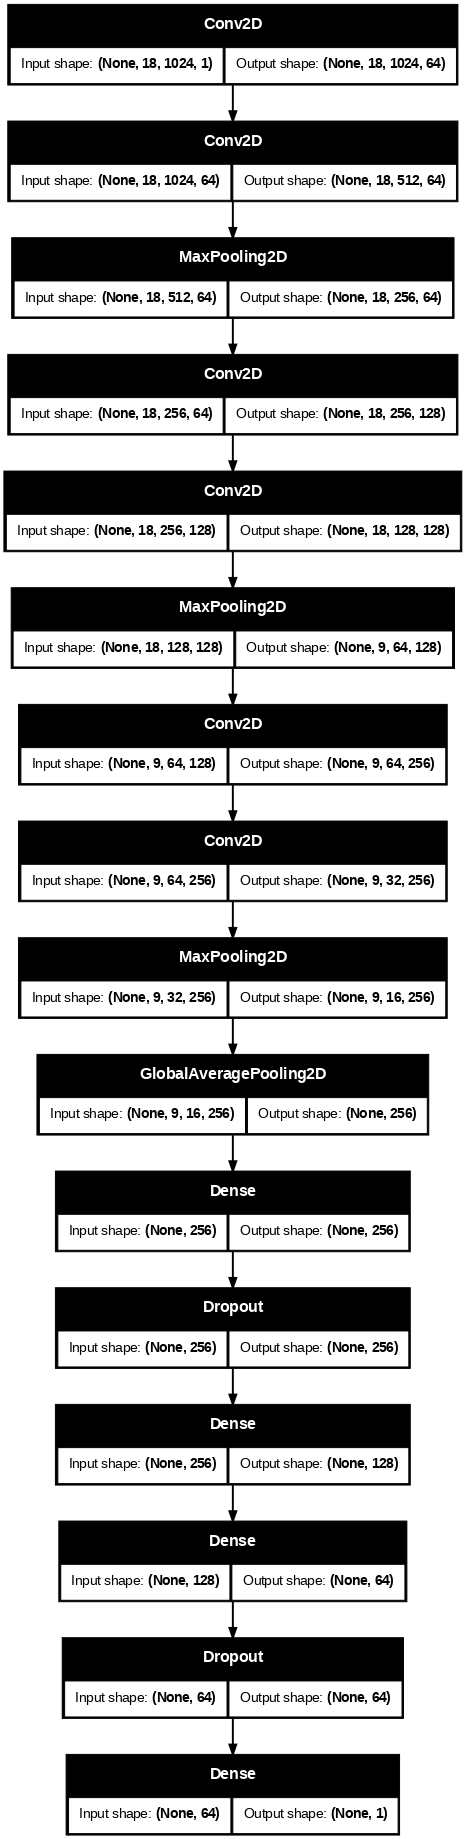

In [40]:
import tensorflow as tf  # Importă biblioteca TensorFlow pentru machine learning și deep learning
from tensorflow import keras  # Importă modulul keras din TensorFlow, o interfață simplificată pentru rețele neuronale
from tensorflow.keras import layers  # Importă modulul pentru definirea straturilor rețelei neuronale (Dense, Conv2D etc.)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping  
# callback1: ReduceLROnPlateau scade rata de învățare dacă performanța stagnează
# callback2: EarlyStopping oprește antrenamentul dacă nu mai există îmbunătățiri (pentru a evita overfitting-ul)


## deep learning model
model = keras.models.Sequential() #creez modelul secvențial, strat cu strat

#filters=filtrele
#kernel_size=(A,B): filtrele sunt de A canale pe B eșantioane
#layers.Conv2D - convolutie
#pooling - operație de reducere a dimensiunii datelor pastrand cele mai importante caracteristici

model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), strides=(1, 2),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((1, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), padding='same', activation='relu'))
model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), strides=(1, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), padding='same', activation='relu'))
model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), strides=(1, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((1, 2)))

model.add(layers.GlobalAveragePooling2D())
#model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

#-------------------------------------------------------------------------------
from keras.utils import plot_model
#plot_model(model, show_shapes=True, to_file='model.png')
plot_model(model, show_shapes=True, dpi=70)

In [41]:
LEARNING_RATE = 1e-4
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy'])

# callbacks
VERBOSE=1
#lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, verbose=VERBOSE, min_le=1e-8)
es = EarlyStopping(monitor='val_loss', patience=20, verbose=VERBOSE, mode='auto', restore_best_weights=True)

callbacks = [es]

X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

((8079, 18, 1024, 1), (8079,), (1426, 18, 1024, 1), (1426,))

## Secțiunea 4.2 - Antrenarea modelului

In [42]:
hist = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_validation, y_validation),
    epochs=200,
    batch_size=256,
    callbacks=callbacks
)

Epoch 1/200


2025-06-21 19:27:10.306081: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[256,256,9,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,128,12,67]{3,2,1,0}, f32[256,128,4,4]{3,2,1,0}, f32[256]{0}), window={size=4x4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-21 19:27:10.945224: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.639372204s
Trying algorithm eng12{k11=0} for conv (f32[256,256,9,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,128,12,67]{3,2,1,0}, f32[256,128,4,4]{3,2,1,0}, f32[256]{0}), window={size=4x4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cu

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.5829 - loss: 0.8257

E0000 00:00:1750534090.480367     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750534090.877075     114 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-21 19:28:10.966532: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=2} for conv (f32[143,128,10,65]{3,2,1,0}, u8[0]{0}) custom-call(f32[143,256,9,64]{3,2,1,0}, f32[256,128,4,4]{3,2,1,0}), window={size=4x4 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-21 19:28:1

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5844 - loss: 0.8228   

2025-06-21 19:28:33.517266: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[256,256,9,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,128,12,67]{3,2,1,0}, f32[256,128,4,4]{3,2,1,0}, f32[256]{0}), window={size=4x4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-21 19:28:33.730050: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.212874113s
Trying algorithm eng12{k11=0} for conv (f32[256,256,9,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,128,12,67]{3,2,1,0}, f32[256,128,4,4]{3,2,1,0}, f32[256]{0}), window={size=4x4}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cu

32/32 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.5858 - loss: 0.8201 - val_accuracy: 0.7286 - val_loss: 0.6771
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 902ms/step - accuracy: 0.7071 - loss: 0.6757 - val_accuracy: 0.7300 - val_loss: 0.6504
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 917ms/step - accuracy: 0.7072 - loss: 0.6438 - val_accuracy: 0.7574 - val_loss: 0.5899
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 928ms/step - accuracy: 0.7593 - loss: 0.5909 - val_accuracy: 0.7770 - val_loss: 0.5466
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 934ms/step - accuracy: 0.7839 - loss: 0.5368 - val_accuracy: 0.7861 - val_loss: 0.5189
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 937ms/step - accuracy: 0.8054 - loss: 0.4831 - val_accuracy: 0.8289 - val_loss: 0.4376
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 941ms/step - accuracy: 0.8144 - loss: 0.4603 - val_accuracy: 0.7728 - val_loss: 0.5211
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 945ms/step - accuracy: 0.7978 - loss: 0.4688 - val_accuracy: 

In [43]:
import pandas as pd

# Creez un DataFrame din istoricul antrenării
history_df = pd.DataFrame(hist.history)

# Salvez ca fișier CSV
history_df.to_csv('training_history_1.csv', index=False)

history_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.631019,0.732963,0.728612,0.677073
1,0.720881,0.667115,0.730014,0.650434
2,0.723852,0.635474,0.757363,0.589850
3,0.757643,0.586245,0.776999,0.546584
4,0.786607,0.533390,0.786115,0.518872


In [44]:
model.save('CHB_MIT_sz_detec_1.h5')

## Secțiunea 4.3 - Grafice pentru evoluția pierderii și acuratețe

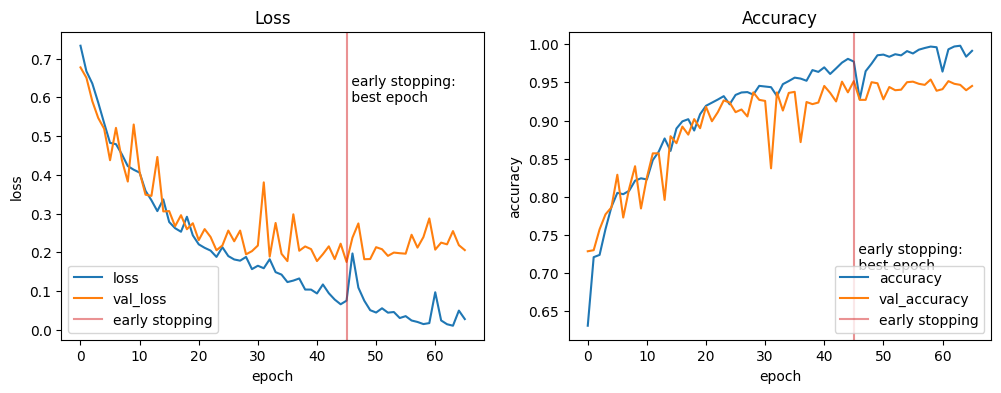

In [45]:
#imediat dupa antrenare
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(hist.history['loss'], label='loss')
ax[0].plot(hist.history['val_loss'], label='val_loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
r = .2
temp_y = r*min(hist.history['loss'])+(1-r)*max(hist.history['loss'])
ax[0].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(hist.history['accuracy'], label='accuracy')
ax[1].plot(hist.history['val_accuracy'], label='val_accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
r = .8
temp_y = r*min(hist.history['accuracy'])+(1-r)*max(hist.history['accuracy'])
ax[1].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
ax[1].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()


In [ ]:
#preia antrenarea din memorie
import pandas as pd
import matplotlib.pyplot as plt

# Încarcă istoricul din fișierul CSV
df = pd.read_csv('/kaggle/input/model-history-training-final/training_history_final.csv')

# Adăugăm o coloană 'epoch' care reprezintă indicele fiecărui rând
df['epoch'] = df.index

# Creăm un dicționar cu valorile necesare pentru plot
hist = {
    'loss': df['loss'].values,
    'val_loss': df['val_loss'].values,
    'accuracy': df['accuracy'].values,
    'val_accuracy': df['val_accuracy'].values
}

# Configurare plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot pentru Loss
ax[0].plot(hist['loss'], label='loss')
ax[0].plot(hist['val_loss'], label='val_loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')

# Mark the early stopping epoch (care este momentul cu min. val_loss)
es_best_epoch = df['val_loss'].idxmin()  # Epoca cu valoarea minimă pentru 'val_loss'
ax[0].axvline(x=es_best_epoch, label='early stopping', color='tab:red', alpha=0.5)
r = .2
temp_y = r*min(hist['loss'])+(1-r)*max(hist['loss'])
ax[0].annotate(' early stopping:\n best epoch', xy=(es_best_epoch, temp_y))
ax[0].set_title('Loss')
ax[0].legend()

# Plot pentru Accuracy
ax[1].plot(hist['accuracy'], label='accuracy')
ax[1].plot(hist['val_accuracy'], label='val_accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')

# Mark the early stopping epoch (care este momentul cu min. val_loss)
r = .8
temp_y = r*min(hist['accuracy'])+(1-r)*max(hist['accuracy'])
ax[1].axvline(x=es_best_epoch, label='early stopping', color='tab:red', alpha=0.5)
ax[1].annotate(' early stopping:\n best epoch', xy=(es_best_epoch, temp_y))
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()


## Secțiunea 4.4 - Modelele

In [ ]:
#run the model without training
import tensorflow as tf
from tensorflow import keras
model = keras.models.load_model('/kaggle/input/cnn_eeg_seizure_model/tensorflow2/default/1/CHB_MIT_sz_detec.h5')

In [ ]:
#run the model without training
import tensorflow as tf
from tensorflow import keras
model = keras.models.load_model('/kaggle/input/cnn_eeg_model_rs2023/tensorflow2/default/1/CHB_MIT_sz_detec_rs2023.h5')

In [11]:
#run the model without training
import tensorflow as tf
from tensorflow import keras
model = keras.models.load_model('/kaggle/input/cnn_eeg_seizure_model_final/tensorflow2/default/1/CHB_MIT_sz_detec_final.h5')

2025-06-21 18:51:05.669913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750531866.210030      32 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750531866.360648      32 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1750531886.079917      32 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750531886.080582      32 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

# Secțiunea 5 - Evaluarea Modelului

In [46]:
mne.set_log_level(verbose='ERROR') #show only error messages

In [47]:
def sampling_data_pred(f, verbose=True):
    #list_signals = []
    #list_is_sz = []
    #n_sample = 40
    if verbose==True:
        print('{}: Reading. '.format(f))
    temp_edf =  mne.io.read_raw_edf(f)
    temp_labels = temp_edf.ch_names
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6 #Extrage datele EEG pentru canalele specifice și le convertește în microvolți

        if os.path.exists(f+'.seizures'):
            if verbose==True:
                print('sz exists.', end=' ')
            temp_annotation = wfdb.rdann(f, 'seizures')
            for i in range(int(temp_annotation.sample.size/2)):
                temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1

        temp_len = temp_edf.n_times

        time_window = 8
        time_step = 4
        fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
        step_window = time_window*fs
        step = time_step*fs

        # sampling all signals
        temp_array_signals = np.array([temp_signals[:, i*step:i*step+step_window] for i in range((temp_len-step_window)//step)])
        temp_is_sz_ind = np.array([temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)])
    else:
        if verbose==True:
            print('EEG {}: Not appropriate channel labels. Reading skipped.'.format(n))

    return temp_array_signals, temp_is_sz_ind

In [48]:
# reading files and prediction
list_pred = []
list_true = []

for f in tqdm.tqdm(files_test):
    array_signals, array_is_sz = sampling_data_pred(f, verbose=False)
    array_signals = array_signals[:, :, ::2, np.newaxis]
    
    list_pred.append(model.predict(array_signals, verbose=0))
    list_true.append(array_is_sz)

100%|██████████| 137/137 [05:04<00:00,  2.22s/it]


## Secțiunea 5.1 - Precision, Recall, F1-score

In [50]:
from sklearn import metrics

# threshold = 0.5
print("=== Classification Report pentru Threshold = 0.5 ===")
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.5)
print(report)

# threshold = 0.9
print("=== Classification Report pentru Threshold = 0.9 ===")
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.9)
print(report)

# threshold = 0.4
print("=== Classification Report pentru Threshold = 0.4 ===")
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.4)
print(report)

=== Classification Report pentru Threshold = 0.5 ===
              precision    recall  f1-score   support

       False       1.00      0.95      0.97    186865
        True       0.05      0.75      0.09       629

    accuracy                           0.95    187494
   macro avg       0.52      0.85      0.53    187494
weighted avg       1.00      0.95      0.97    187494

=== Classification Report pentru Threshold = 0.9 ===
              precision    recall  f1-score   support

       False       1.00      0.98      0.99    186865
        True       0.09      0.71      0.16       629

    accuracy                           0.98    187494
   macro avg       0.55      0.84      0.58    187494
weighted avg       1.00      0.98      0.98    187494

=== Classification Report pentru Threshold = 0.4 ===
              precision    recall  f1-score   support

       False       1.00      0.94      0.97    186865
        True       0.04      0.77      0.08       629

    accuracy           

## Secțiunea 5.2 - Curba ROC

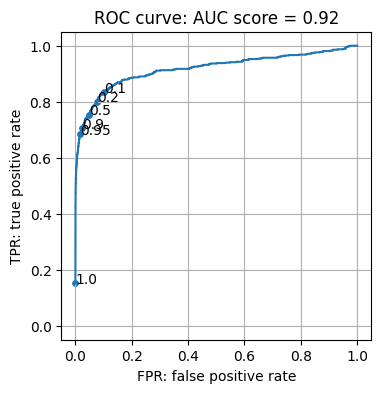

In [51]:
roc = metrics.roc_curve(np.concatenate(list_true)>0, np.concatenate(list_pred))
auc = metrics.roc_auc_score(np.concatenate(list_true)>0, np.concatenate(list_pred))
plt.figure(figsize=(4, 4))
plt.plot(roc[0][np.argmin(np.abs(roc[2]-1)):], roc[1][np.argmin(np.abs(roc[2]-1)):])
plt.xlabel('FPR: false positive rate')
plt.ylabel('TPR: true positive rate')
plt.title('ROC curve: AUC score = {:.2f}'.format(auc))

th = [.1, .2, .5, .9, .95, 1.]
ind = [np.argmin(np.abs(roc[2]-l)) for l in th]
plt.scatter(roc[0][ind], roc[1][ind], s=15)
for i, l in enumerate(ind):
    plt.annotate("{}".format(th[i]), xy=(roc[0][l], roc[1][l]))
#plt.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], color='black', linewidth=1)
plt.ylim(-.05, 1.05)
plt.xlim(-.05, 1.05)
plt.grid()
#plt.axis('off')
plt.show()

## Secțiunea 5.3 - Matricea de confuzie

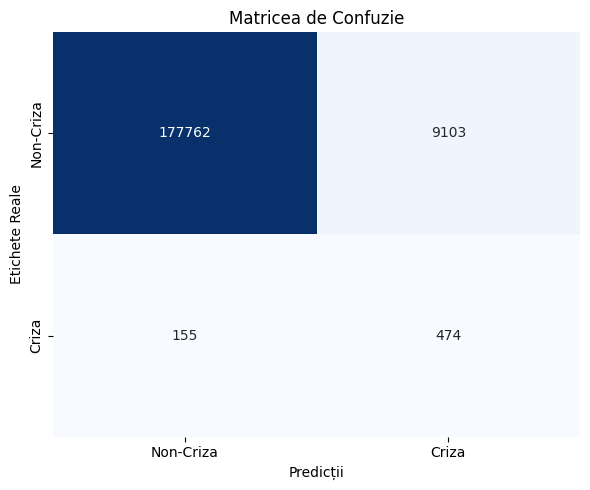

Număr de non-crize reale (TN): 177762
Număr de crize reale (TP): 474
Număr de non-crize prezise greșit (FP): 9103
Număr de crize prezise greșit (FN): 155

Explicație:
Din totalul crizelor reale (629), modelul a prezis corect 474 crize și a prezis greșit 155.
Din totalul non-crizelor reale (186865), modelul a prezis corect 177762 non-crize și a prezis greșit 9103.


In [53]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Inițializare matrice de confuzie
cm_total = np.array([[0, 0], [0, 0]])

# Threshold-ul dorit
threshold = 0.5

# Construim matricea pe bucăți
for y_true, y_pred in zip(list_true, list_pred):
    # Binarizare
    y_true_bin = (y_true > 0).astype(int).flatten()
    y_pred_bin = (y_pred > threshold).astype(int).flatten()

    # Calcul local și adunare
    cm = confusion_matrix(y_true_bin, y_pred_bin, labels=[0, 1])
    cm_total += cm

# Vizualizare frumoasă
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cm_df = pd.DataFrame(cm_total, index=["Non-Criza", "Criza"], columns=["Non-Criza", "Criza"])
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matricea de Confuzie")
plt.xlabel("Predicții")
plt.ylabel("Etichete Reale")
plt.tight_layout()
plt.show()

# Extragem valorile din matricea totală
TN, FP, FN, TP = cm_total.ravel()

print(f"Număr de non-crize reale (TN): {TN}")
print(f"Număr de crize reale (TP): {TP}")
print(f"Număr de non-crize prezise greșit (FP): {FP}")
print(f"Număr de crize prezise greșit (FN): {FN}")

print("\nExplicație:") 
print(f"Din totalul crizelor reale ({TP + FN}), modelul a prezis corect {TP} crize și a prezis greșit {FN}.") 
print(f"Din totalul non-crizelor reale ({TN + FP}), modelul a prezis corect {TN} non-crize și a prezis greșit {FP}.")

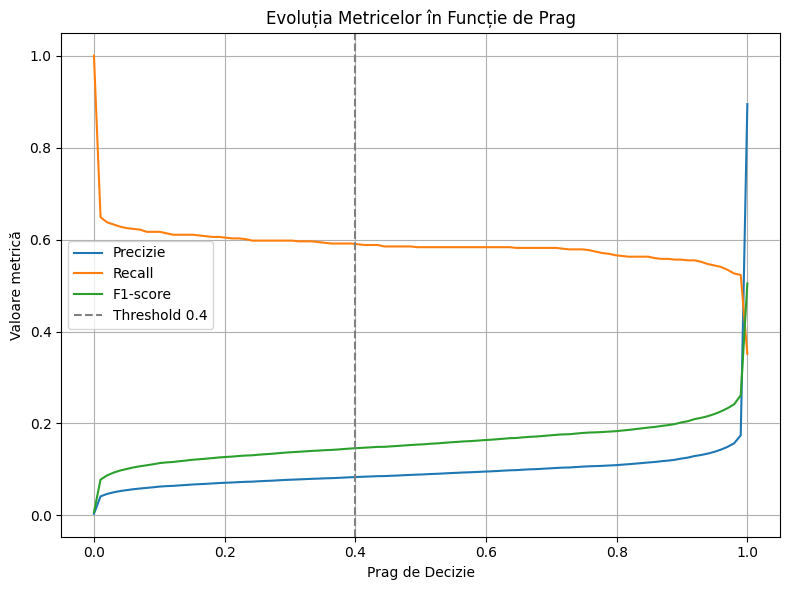

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Datele binare reale
y_true_bin = (np.concatenate(list_true) > 0).astype(int)
y_scores = np.concatenate(list_pred).flatten()

thresholds = np.linspace(0, 1, 100)
precisions = []
recalls = []
f1s = []

for t in thresholds:
    y_pred_bin = (y_scores >= t).astype(int)
    precisions.append(precision_score(y_true_bin, y_pred_bin, zero_division=0))
    recalls.append(recall_score(y_true_bin, y_pred_bin, zero_division=0))
    f1s.append(f1_score(y_true_bin, y_pred_bin, zero_division=0))

# Plot metrice
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label="Precizie")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1-score")
plt.axvline(x=0.4, color='gray', linestyle='--', label="Threshold 0.4")
plt.xlabel("Prag de Decizie")
plt.ylabel("Valoare metrică")
plt.title("Evoluția Metricelor în Funcție de Prag")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Secțiunea 5.4 - Seizure detection point

In [54]:
for i, f in enumerate(files_test):
    if os.path.exists(f+'.seizures'):
        print('Index = {} has seizures: {}'.format(i, f))

Index = 9 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_18.edf
Index = 11 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_26.edf
Index = 12 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_03.edf
Index = 20 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_16.edf
Index = 24 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_04.edf
Index = 30 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_21.edf
Index = 37 has seizures: /kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb01/chb01_15.edf
Index = 50 has seizures: /kaggle/in

In [55]:
def moving_ave(a, n):
    if len(a.shape)!=1:
        print('Not 1 dimension array. return nothing.')
        return
    temp = np.zeros(a.size-n)
    for i in range(n):
        temp = temp+a[i:-n+i]
    temp = temp/n
    
    return temp


# get signals and labels from test data.
n=100
array_signals, array_is_sz = sampling_data_pred(files_test[n])

# preprocess
array_signals=array_signals[:, :, ::2, np.newaxis]

# use deep learning model
pred = model.predict(array_signals)

/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0/chb10/chb10_89.edf: Reading. 
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


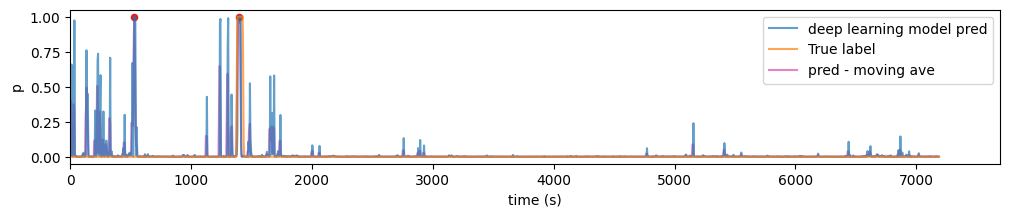

In [56]:
time_window = 8
time_step = 4
mv_win = 3

fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(np.arange(pred.size)*time_step, pred.flatten(), alpha=0.7, label='deep learning model pred')
ax.plot(np.arange(pred.size)*time_step, array_is_sz, alpha=.7, label='True label')

pred_moving_ave = moving_ave(pred.flatten(), mv_win)
pred_peaks, _ = find_peaks(pred_moving_ave, height=.95, distance=6)
ax.plot(np.arange(pred.size-mv_win)*time_step, pred_moving_ave,
        alpha=.9, label='pred - moving ave', color='tab:pink', zorder=0)
ax.scatter(pred_peaks*time_step, pred_moving_ave[pred_peaks], s=20, color='tab:red')

ax.set_xlabel('time (s)')
ax.set_ylabel('p')
ax.set_xlim(0, pred.size*time_step+500)
ax.legend(loc='upper right')
plt.show()

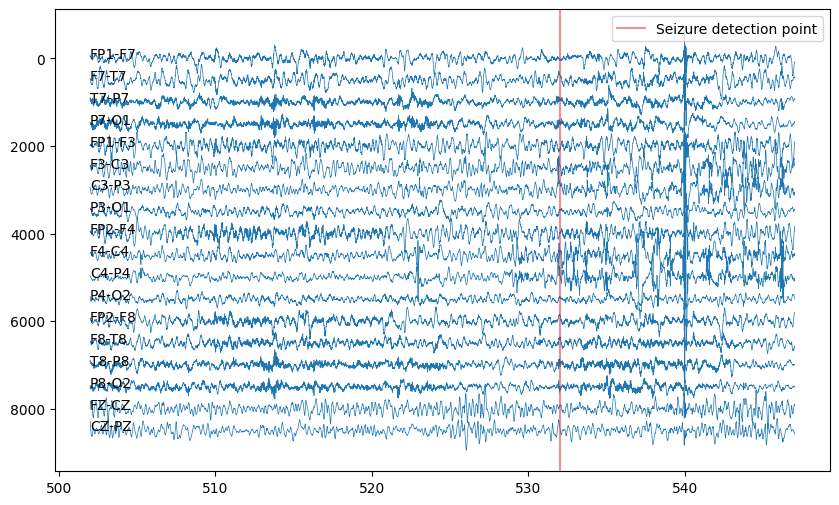

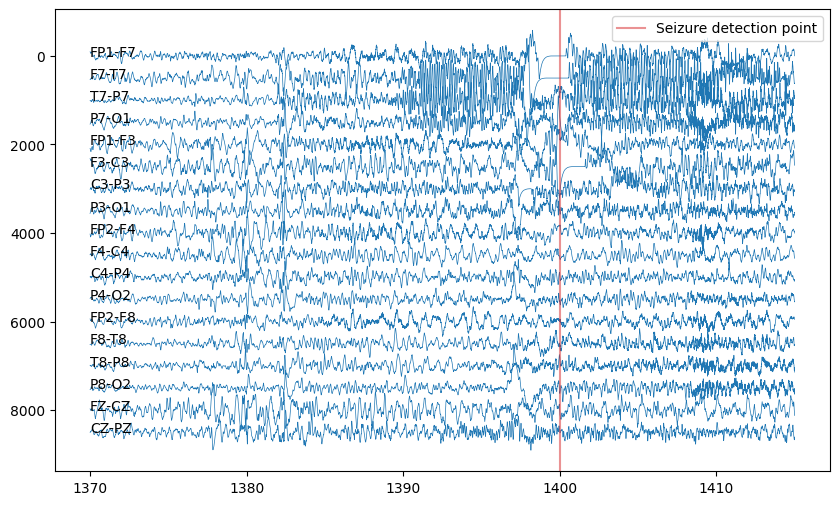

In [57]:
if pred_peaks.size==0:
    print('No seizure detected.')
else:
    f = files_test[n]
    temp_edf =  mne.io.read_raw_edf(f)
    temp_labels = temp_edf.ch_names
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

    fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
    for n_peak in range(pred_peaks.size):
        ind_peak = pred_peaks[n_peak]*time_step*fs
        backward_steps = 30*fs
        forward_steps = 15*fs
        vertical_width=500

        fig, ax = plt.subplots(figsize=(10, 6))
        for i in range(temp_signals.shape[0]):
            ax.plot(np.arange(ind_peak-backward_steps, ind_peak+forward_steps)/fs,
                    temp_signals[i, ind_peak-backward_steps:ind_peak+forward_steps]+i*vertical_width, linewidth=0.5, color='tab:blue')
            ax.annotate(ch_labels[i], xy=((ind_peak-backward_steps)/fs, i*vertical_width))
        ax.axvline(x=ind_peak/fs, color='tab:red', alpha=0.5, label='Seizure detection point')
        ax.invert_yaxis()
        ax.legend(loc='upper right')
        plt.show()
    #ax.set_xlim(0, 8)

    temp_edf.close()

# EXTRA

**HEATMAPS**  **training part**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm  # pentru bara de progres

# Creează foldere pentru imaginile de train
os.makedirs('/kaggle/working/heatmaps/train/criza', exist_ok=True)
os.makedirs('/kaggle/working/heatmaps/train/non_criza', exist_ok=True)

# Funcție care salvează heatmap-ul
def save_heatmap(signal, path):
    plt.figure(figsize=(4, 4))
    plt.axis('off')
    plt.pcolormesh(signal, cmap='gray')
    plt.gca().invert_yaxis()
    plt.tight_layout(pad=0)
    plt.savefig(path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Salvează imaginile de antrenare
for idx in tqdm(range(X_train.shape[0]), desc="Generăm heatmap-uri pentru train"):
    label = 'criza' if y_train[idx] else 'non_criza'
    save_path = f'/kaggle/working/heatmaps/train/{label}/{idx}.png'
    save_heatmap(X_train[idx, :, :], save_path)


In [ ]:
import zipfile
import os

# Setează calea către folderul care conține imaginile
folder_path = '/kaggle/working/heatmaps/train'

# Numele fișierului zip
zip_file = '/kaggle/working/heatmaps_train.zip'

# Creează un fișier zip
with zipfile.ZipFile(zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Parcurge folderele din directory
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Adaugă fiecare fișier .png la arhivă
            if file.endswith('.png'):
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), folder_path))

print(f'Fișierul zip a fost creat la {zip_file}')

import shutil

# Muta arhiva într-un loc accesibil pentru download
shutil.move(zip_file, '/kaggle/working/heatmaps_train.zip')

# Link de descărcare
from IPython.display import FileLink

# Crează un link de descărcare
FileLink(r'/kaggle/working/heatmaps_train.zip')

In [ ]:
import pandas as pd
import os

image_paths = []
labels = []

base_path = '/kaggle/working/heatmaps/train'

for label in ['criza', 'non_criza']:
    full_path = os.path.join(base_path, label)
    for fname in os.listdir(full_path):
        if fname.endswith('.png'):
            image_paths.append(os.path.join(full_path, fname))
            labels.append(label)

train_df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

train_df.to_csv('/kaggle/working/train_dataset.csv', index=False)

print("CSV-ul a fost creat pe baza imaginilor existente.")


In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Creează foldere pentru imaginile de train
os.makedirs('/kaggle/working/heatmaps/train/criza', exist_ok=True)
os.makedirs('/kaggle/working/heatmaps/train/non_criza', exist_ok=True)

# Funcție care salvează heatmap-ul
def save_heatmap(signal, path):
    plt.figure(figsize=(4, 4))
    plt.axis('off')
    plt.pcolormesh(signal, cmap='gray')
    plt.gca().invert_yaxis()
    plt.tight_layout(pad=0)
    plt.savefig(path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Creăm o listă pentru căile fișierelor și etichetele corespunzătoare
image_paths = []
labels = []

# Salvează imaginile de antrenare
for idx in tqdm(range(X_train.shape[0]), desc="Generăm heatmap-uri pentru train"):
    label = 'criza' if y_train[idx] else 'non_criza'
    save_path = f'/kaggle/working/heatmaps/train/{label}/{idx}.png'
    save_heatmap(X_train[idx, :, :], save_path)
    
    # Adăugăm calea fișierului și eticheta în liste
    image_paths.append(save_path)
    labels.append(label)

# Creăm un DataFrame din listele de căi și etichete
train_df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Salvăm DataFrame-ul ca fișier CSV
train_df.to_csv('/kaggle/working/train_dataset.csv', index=False)

print("Dataset-ul pentru train a fost salvat ca fișier CSV.")


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# from tqdm import tqdm  # pentru bara de progres

# # Creează foldere pentru imagini
# os.makedirs('/kaggle/working/heatmaps/train/criza', exist_ok=True)
# os.makedirs('/kaggle/working/heatmaps/train/non_criza', exist_ok=True)
# os.makedirs('/kaggle/working/heatmaps/test/criza', exist_ok=True)
# os.makedirs('/kaggle/working/heatmaps/test/non_criza', exist_ok=True)

# # Funcție care salvează heatmap-ul
# def save_heatmap(signal, path):
#     plt.figure(figsize=(4, 4))
#     plt.axis('off')
#     plt.pcolormesh(signal, cmap='gray')  # poți schimba cmap dacă vrei alt efect
#     plt.gca().invert_yaxis()
#     plt.tight_layout(pad=0)
#     plt.savefig(path, bbox_inches='tight', pad_inches=0)
#     plt.close()

# # Salvează imaginile de antrenare
# for idx in tqdm(range(X_train.shape[0]), desc="Generăm heatmap-uri pentru train"):
#     label = 'criza' if y_train[idx] else 'non_criza'
#     save_path = f'/kaggle/working/heatmaps/train/{label}/{idx}.png'
#     save_heatmap(X_train[idx, :, :], save_path)

# # Salvează imaginile de testare
# for idx in tqdm(range(X_test.shape[0]), desc="Generăm heatmap-uri pentru test"):
#     label = 'criza' if y_test[idx] else 'non_criza'
#     save_path = f'/kaggle/working/heatmaps/test/{label}/{idx}.png'
#     save_heatmap(X_test[idx, :, :], save_path)


In [ ]:
# import numpy as np
# import os
# import random
# import gc
# import tqdm
# import logging
# import mne
# import wfdb
# import re

# # Creează un sistem de logare pentru monitorizarea fișierelor procesate
# logger = logging.getLogger(__name__)
# fh = logging.FileHandler('read_files.log')
# logger.addHandler(fh)

# # Parametrii pentru segmentare
# time_window = 8  # Fereastră de 8 secunde
# time_step = 4  # Suprapunere de 50% (alunecare de 4 secunde)
# p = 0.01  # Proporția de segmente fără crize extrase
# counter = 0  # Contor pentru numărul total de segmente EEG extrase

# # Se citește fiecare fișier EEG
# for temp_f in files_train:  
#     temp_edf = mne.io.read_raw_edf(temp_f)  
#     temp_labels = temp_edf.ch_names  

#     # Verifică dacă toate canalele necesare sunt prezente
#     if sum([any([0 if re.match(c, l) is None else 1 for l in temp_edf.ch_names]) for c in ch_labels]) == len(ch_labels):

#         fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))  # Rata de eșantionare
#         step_window = time_window * fs  # Dimensiunea fiecărei ferestre (în eșantioane)
#         step = time_step * fs  # Alunecare de **4 secunde** pentru suprapunere de 50%

#         # Începem segmentarea **de la secunda 1** -> calculăm indexul corespunzător în eșantioane
#         start_index = fs  # 1 sec * frecvența de eșantionare

#         temp_is_sz = np.zeros((temp_edf.n_times,))  # Inițializare array cu 0 (fără criză)

#         # Verifică dacă fișierul .seizures există și marchează crizele
#         if os.path.exists(temp_f + '.seizures'):
#             temp_annotation = wfdb.rdann(temp_f, 'seizures')
#             for i in range(int(temp_annotation.sample.size / 2)):
#                 temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1  # Marcare crize

#         temp_len = temp_edf.n_times

#         # Crearea vectorului de proporție a crizelor **pornind de la secunda 1**
#         temp_is_sz_ind = np.array([
#             temp_is_sz[start_index + i * step:start_index + i * step + step_window].sum() / step_window
#             for i in range((temp_len - start_index - step_window) // step)
#         ])

#         # Se calculează câte segmente cu și fără crize vor fi extrase
#         temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
#         temp_1_sample_size = np.where(temp_is_sz_ind > 0)[0].size

#         counter += temp_0_sample_size + temp_1_sample_size

#     temp_edf.close()

# # Crearea array-urilor după ce s-au calculat dimensiunile totale
# array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
# array_is_sz = np.zeros(counter, dtype=bool)
# source_files = []

# # Citește din nou fișierele și extrage efectiv semnalele
# counter = 0
# for n, temp_f in enumerate(tqdm.tqdm(files_train)):
#     to_log = 'No. {}: Reading. '.format(n)
#     temp_edf = mne.io.read_raw_edf(temp_f)

#     temp_labels = temp_edf.ch_names
#     n_label_match = sum([any([0 if re.match(c, l) is None else 1 for l in temp_edf.ch_names]) for c in ch_labels])

#     if n_label_match == len(ch_labels):
#         ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l) is not None])[0]: c for c in ch_labels}
#         temp_edf.rename_channels(ch_mapping)

#         temp_is_sz = np.zeros((temp_edf.n_times,))
#         temp_signals = temp_edf.get_data(picks=ch_labels) * 1e6

#         if os.path.exists(temp_f + '.seizures'):
#             to_log += 'sz exists.'
#             temp_annotation = wfdb.rdann(temp_f, 'seizures')
#             for i in range(int(temp_annotation.sample.size / 2)):
#                 temp_is_sz[temp_annotation.sample[i * 2]:temp_annotation.sample[i * 2 + 1]] = 1

#         temp_len = temp_edf.n_times

#         fs = int(1 / (temp_edf.times[1] - temp_edf.times[0]))  # Frecvența de eșantionare
#         step_window = time_window * fs
#         step = time_step * fs  # Acum alunecă 4 secunde pentru suprapunere de 50%

#         # **Pornim de la secunda 2**
#         start_index = 2*fs  

#         temp_is_sz_ind = np.array([
#             temp_is_sz[start_index + i * step:start_index + i * step + step_window].sum() / step_window
#             for i in range((temp_len - start_index - step_window) // step)
#         ])
#         del temp_is_sz

#         temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
#         temp_1_sample_size = np.where(temp_is_sz_ind > 0)[0].size

#         # Adăugarea semnalelor cu crize
#         temp_ind = list(np.where(temp_is_sz_ind > 0)[0])
#         for i in temp_ind:
#             array_signals[counter, :, :] = temp_signals[:, start_index + i * step:start_index + i * step + step_window]
#             array_is_sz[counter] = True
#             source_files.append(temp_f)
#             counter += 1

#         # Adăugarea semnalelor fără crize
#         temp_ind = random.sample(list(np.where(temp_is_sz_ind == 0)[0]), temp_0_sample_size)
#         for i in temp_ind:
#             array_signals[counter, :, :] = temp_signals[:, start_index + i * step:start_index + i * step + step_window]
#             array_is_sz[counter] = False
#             source_files.append(temp_f)
#             counter += 1

#         to_log += '{} signals added: {} w/o sz, {} w/ sz.'.format(temp_0_sample_size + temp_1_sample_size, temp_0_sample_size, temp_1_sample_size)

#     else:
#         to_log += 'Not appropriate channel labels. Reading skipped.'.format(n)

#     logger.info(to_log)
#     temp_edf.close()

#     if n % 10 == 0:
#         gc.collect()
# gc.collect()

# # Salvarea array-urilor rezultate
# np.save('/kaggle/working/signal_samples.npy', array_signals)
# np.save('/kaggle/working/is_sz.npy', array_is_sz)
# np.save('/kaggle/working/source_files.npy', np.array(source_files))

# array_signals.shape  # (num_windows, num_channels, window_length_samples)

In [ ]:
# #incepand cu secundele 1,2,3 pentru toti copiii
# !pip install wfdb

# import logging
# import random
# import numpy as np
# import mne
# import wfdb
# import os
# import gc
# import tqdm
# import matplotlib.pyplot as plt

# # Set up logging
# logger = logging.getLogger(__name__)
# fh = logging.FileHandler('read_files.log')
# logger.addHandler(fh)

# # Window parameters
# time_window = 8  # 8 seconds
# fs = 256  # default sampling frequency
# step_window = time_window * fs
# p = 0.01

# # Calculate total segments across all files
# counter = 0
# for temp_f in files_train:
#     temp_edf = mne.io.read_raw_edf(temp_f)
#     if all(any(re.match(c, l) for l in temp_edf.ch_names) for c in ch_labels):
#         temp_len = temp_edf.n_times
#         temp_is_sz = np.zeros(temp_len)
#         if os.path.exists(temp_f + '.seizures'):
#             temp_annotation = wfdb.rdann(temp_f, 'seizures')
#             for i in range(temp_annotation.sample.size // 2):
#                 temp_is_sz[temp_annotation.sample[i * 2] : temp_annotation.sample[i * 2 + 1]] = 1
        
#         # Include start offsets (0s, 1s, 2s, 3s)
#         for offset in range(fs, 4 * fs, fs):
#             temp_is_sz_ind = np.array([
#                 temp_is_sz[i * fs + offset : i * fs + offset + step_window].sum() / step_window
#                 for i in range((temp_len - offset - step_window) // fs)
#             ])
#             counter += round(p * np.where(temp_is_sz_ind == 0)[0].size)
#             counter += np.where(temp_is_sz_ind > 0)[0].size
#     temp_edf.close()

# del temp_is_sz

# # Initialize arrays
# array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
# array_is_sz = np.zeros(counter, dtype=bool)
# source_files = []

# # Extract and store segments
# counter = 0
# for n, temp_f in enumerate(tqdm.tqdm(files_train)):
#     temp_edf = mne.io.read_raw_edf(temp_f)
#     if all(any(re.match(c, l) for l in temp_edf.ch_names) for c in ch_labels):
#         temp_signals = temp_edf.get_data(picks=ch_labels) * 1e6
#         temp_len = temp_edf.n_times
#         temp_is_sz = np.zeros(temp_len)
#         if os.path.exists(temp_f + '.seizures'):
#             temp_annotation = wfdb.rdann(temp_f, 'seizures')
#             for i in range(temp_annotation.sample.size // 2):
#                 temp_is_sz[temp_annotation.sample[i * 2] : temp_annotation.sample[i * 2 + 1]] = 1
        
#         for offset in range(0, 4 * fs, fs):
#             temp_is_sz_ind = np.array([
#                 temp_is_sz[i * fs + offset : i * fs + offset + step_window].sum() / step_window
#                 for i in range((temp_len - offset - step_window) // fs)
#             ])
            
#             # Extract seizure data
#             temp_ind = list(np.where(temp_is_sz_ind > 0)[0])
#             for i in temp_ind:
#                 array_signals[counter, :, :] = temp_signals[:, i * fs + offset : i * fs + offset + step_window]
#                 array_is_sz[counter] = True
#                 source_files.append(temp_f)
#                 counter += 1
            
#             # Extract non-seizure data
#             temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
#             temp_ind = random.sample(list(np.where(temp_is_sz_ind == 0)[0]), temp_0_sample_size)
#             for i in temp_ind:
#                 array_signals[counter, :, :] = temp_signals[:, i * fs + offset : i * fs + offset + step_window]
#                 array_is_sz[counter] = False
#                 source_files.append(temp_f)
#                 counter += 1
#     temp_edf.close()
#     if n % 10 == 0:
#         gc.collect()

# gc.collect()
# np.save('/kaggle/working/signal_samples_2.npy', array_signals)
# np.save('/kaggle/working/is_sz_2.npy', array_is_sz)
# np.save('/kaggle/working/source_files.npy', np.array(source_files))

# # Visualization of window distribution
# signals = np.load('/kaggle/working/signal_samples_2.npy')
# labels = np.load('/kaggle/working/is_sz_2.npy')
# sources = np.load('/kaggle/working/source_files_2.npy')

# print("Total number of windows:", signals.shape[0])
# print("Number of seizure windows:", labels.sum())
# print("Number of non-seizure windows:", len(labels) - labels.sum())

# plt.figure(figsize=(10, 6))
# plt.hist(labels, bins=2, color='skyblue', rwidth=0.8)
# plt.xticks([0, 1], ["Non-Seizure", "Seizure"])
# plt.title("Distribution of Seizure and Non-Seizure Windows")
# plt.show()

In [ ]:
# import mne

# # Verifică canalele disponibile în primul fișier chb02
# temp_f = [f for f in files_train if "chb02_" in f][0]
# raw = mne.io.read_raw_edf(temp_f, preload=False)
# print(raw.ch_names)

In [ ]:
# #incepand cu secundele 1,2,3 pentru chb_02
# import logging
# import random
# import numpy as np
# import mne
# import wfdb
# import os
# import gc
# import tqdm
# import matplotlib.pyplot as plt

# # Set up logging
# logger = logging.getLogger(__name__)
# fh = logging.FileHandler('read_files_chb02.log')
# logger.addHandler(fh)

# # Window parameters
# time_window = 8  # 8 seconds
# fs = 256  # default sampling frequency
# step_window = time_window * fs
# p = 0.01

# ch_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 
#              'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 
#              'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 
#              'FT10-T8', 'T8-P8-1']

# # Filter files for chb02 only
# files_chb02 = [f for f in files_train if "chb02_" in f]

# # Calculate total segments for chb02
# counter = 0
# for temp_f in files_chb02:
#     temp_edf = mne.io.read_raw_edf(temp_f)
#     if all(any(re.match(c, l) for l in temp_edf.ch_names) for c in ch_labels):
#         temp_len = temp_edf.n_times
#         temp_is_sz = np.zeros(temp_len)
#         if os.path.exists(temp_f + '.seizures'):
#             temp_annotation = wfdb.rdann(temp_f, 'seizures')
#             for i in range(temp_annotation.sample.size // 2):
#                 temp_is_sz[temp_annotation.sample[i * 2] : temp_annotation.sample[i * 2 + 1]] = 1
        
#         # Include start offsets (1s, 2s, 3s)
#         for offset in [1 * fs, 2 * fs, 3 * fs]:
#             temp_is_sz_ind = np.array([
#                 temp_is_sz[i * fs + offset : i * fs + offset + step_window].sum() / step_window
#                 for i in range((temp_len - offset - step_window) // fs)
#             ])
#             counter += round(p * np.where(temp_is_sz_ind == 0)[0].size)
#             counter += np.where(temp_is_sz_ind > 0)[0].size
#     temp_edf.close()

# del temp_is_sz

# # Initialize arrays
# array_signals_02 = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
# array_is_sz_02 = np.zeros(counter, dtype=bool)
# source_files = []

# # Extract and store segments for chb02
# counter = 0
# for n, temp_f in enumerate(tqdm.tqdm(files_chb02)):
#     temp_edf = mne.io.read_raw_edf(temp_f)
#     if all(any(re.match(c, l) for l in temp_edf.ch_names) for c in ch_labels):
#         temp_signals = temp_edf.get_data(picks=ch_labels) * 1e6
#         temp_len = temp_edf.n_times
#         temp_is_sz = np.zeros(temp_len)
#         if os.path.exists(temp_f + '.seizures'):
#             temp_annotation = wfdb.rdann(temp_f, 'seizures')
#             for i in range(temp_annotation.sample.size // 2):
#                 temp_is_sz[temp_annotation.sample[i * 2] : temp_annotation.sample[i * 2 + 1]] = 1
        
#         # Include start offsets (1s, 2s, 3s)
#         for offset in [1 * fs, 2 * fs, 3 * fs]:
#             temp_is_sz_ind = np.array([
#                 temp_is_sz[i * fs + offset : i * fs + offset + step_window].sum() / step_window
#                 for i in range((temp_len - offset - step_window) // fs)
#             ])
            
#             # Extract seizure data
#             temp_ind = list(np.where(temp_is_sz_ind > 0)[0])
#             for i in temp_ind:
#                 array_signals_02[counter, :, :] = temp_signals[:, i * fs + offset : i * fs + offset + step_window]
#                 array_is_sz_02[counter] = True
#                 source_files.append(temp_f)
#                 counter += 1
            
#             # Extract non-seizure data
#             temp_0_sample_size = round(p * np.where(temp_is_sz_ind == 0)[0].size)
#             temp_ind = random.sample(list(np.where(temp_is_sz_ind == 0)[0]), temp_0_sample_size)
#             for i in temp_ind:
#                 array_signals_02[counter, :, :] = temp_signals[:, i * fs + offset : i * fs + offset + step_window]
#                 array_is_sz_02[counter] = False
#                 source_files.append(temp_f)
#                 counter += 1
#     temp_edf.close()
#     if n % 10 == 0:
#         gc.collect()

# gc.collect()
# np.save('/kaggle/working/signal_samples_chb02.npy', array_signals)
# np.save('/kaggle/working/is_sz_chb02.npy', array_is_sz)
# np.save('/kaggle/working/source_files_chb02.npy', np.array(source_files))

# # Visualization of window distribution
# signals = np.load('/kaggle/working/signal_samples_chb02.npy')
# labels = np.load('/kaggle/working/is_sz_chb02.npy')
# sources = np.load('/kaggle/working/source_files_chb02.npy')

# print("Total number of windows (chb02):", signals.shape[0])
# print("Number of seizure windows (chb02):", labels.sum())
# print("Number of non-seizure windows (chb02):", len(labels) - labels.sum())

# plt.figure(figsize=(10, 6))
# plt.hist(labels, bins=2, color='skyblue', rwidth=0.8)
# plt.xticks([0, 1], ["Non-Seizure", "Seizure"])
# plt.title("Distribution of Seizure and Non-Seizure Windows (chb02)")
# plt.show()